In [1]:
!pip install spacy==3.2.0 -q
!pip install tensorflow -q
!pip install matplotlib -q
!pip install pyspellchecker -q
!pip install nltk -q
!pip install seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from spellchecker import SpellChecker
import time
from multiprocessing import  Pool
from nltk.stem import WordNetLemmatizer 
import io
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import string

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Activation, SimpleRNN,Dense

import spacy
from spacy.lang.en.stop_words import STOP_WORDS


  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\conta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
speech1 = pd.read_csv('train_data2.csv', index_col = 'id')

#Second dataset to balance the first one
speech2 = pd.read_csv('labeled_data.csv', index_col = 'Unnamed: 0') 


In [3]:
speech1

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


In [4]:
speech1['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [5]:
speech2 = speech2.loc[:,['tweet', 'class']] 
# Séparer les classes 'Hate', 'Offensive', 'Neutral' en 2 classes binaires : offensif ou neutre
speech2['good_bad'] = speech2['class'].apply(lambda x : 0 if x == 0 or x == 1
                                                        else 1)
speech2.dropna(axis = 0)
speech2 = speech2[speech2['good_bad'] == 1] #On ne gardera que les ligne où les tweets sont considérés offensifs.
speech2.drop(columns = 'class', inplace = True)
speech2 = speech2[speech2.columns[::-1]] #Changer l'ordre des colones afin de concatener les deux dataframes
speech2.rename(columns = {'good_bad' : 'label'}, inplace = True)
speech2

,label,tweet
0,1,!!! RT @mayasolovely: As a woman you shouldn't...
40,1,""" momma said no pussy cats inside my doghouse """
63,1,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,1,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,1,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."
...,...,...
25249,1,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
25250,1,yea so about @N_tel 's new friend.. all my fri...
25280,1,"you know what they say, the early bird gets th..."
25292,1,"you've gone and broke the wrong heart baby, an..."


In [6]:
speech3 = pd.concat([speech1,speech2], axis=0)
speech3['label'].value_counts()

0    29720
1     6405
Name: label, dtype: int64

In [7]:
#Créer un dataframe équilibré.
speech3[speech3['label'] == 1 ]
speech3[speech3['label'] == 0 ].sample(speech3[speech3['label'] == 1 ].count()[0])

,label,tweet
22932,0,"how the @user made grandma sad. #grandma, #l..."
10886,0,i am independent. #i_am #positive #affirmation...
15443,0,enjoy #lifeofaking starring cuba gooding jr ! ...
15569,0,going to #fabcon3d tomorrow! talk scheduled fo...
26575,0,@user went to fye and they didn't have your al...
...,...,...
21724,0,@user take a look. #ukip in scotland are non...
31829,0,happy daddy's day to all the fab dads out ther...
28635,0,a girl broken his hea ð ð ââââ #...
11916,0,update: my free app will be live within 7 days.


In [8]:
speech = pd.concat([
                    speech3[speech3['label'] == 1] ,
                    speech3[speech3['label'] == 0].sample(speech3[speech3['label'] == 1 ].count()[0]
                    )],
                    axis = 0 )

speech = speech.sample(frac=1) #Shuffling du dataset
speech = speech.reset_index() #Resetting index
speech= speech.drop('index', axis = 1)

#aligner les noms de colonnes

speech.rename(columns = {'tweet' : 'text'}, inplace = True)
speech

,label,text
0,1,#newyearseve #skynews presenter to asian woman...
1,1,"@LILNTHEBASEDGOD her face ugly to me, &amp; he..."
2,0,oh how disappointed i was to see that there wa...
3,1,"""the dying of the light"" village green/townÂ²..."
4,1,@BlackManUSA @chrislhayes well that's some cra...
...,...,...
12805,0,@user i have missed radio next week back in t...
12806,1,"RT @WorIdStarFunnyy: this the ""I play soccer, ..."
12807,0,kim taeyeon! @user new project coming up.
12808,1,"""@BabyAnimalPics: baby monkey bathtime http://..."


In [9]:
speech.head()

,label,text
0,1,#newyearseve #skynews presenter to asian woman...
1,1,"@LILNTHEBASEDGOD her face ugly to me, &amp; he..."
2,0,oh how disappointed i was to see that there wa...
3,1,"""the dying of the light"" village green/townÂ²..."
4,1,@BlackManUSA @chrislhayes well that's some cra...


In [10]:
speech['label'].value_counts()

1    6405
0    6405
Name: label, dtype: int64

In [11]:
speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12810 entries, 0 to 12809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   12810 non-null  int64 
 1   text    12810 non-null  object
dtypes: int64(1), object(1)
memory usage: 200.3+ KB


##### 

### Preprocessing texts

In [12]:
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [13]:
nlp = spacy.load("en_core_web_md")

In [14]:
# https://stackoverflow.com/a/47091490
def decontracted(phrase):
    """Convert contractions like "can't" into "can not"
    """
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    #phrase = re.sub(r"n't", " not", phrase) # resulted in "ca not" when sentence started with "can't"
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}


def unslang(text):
    """Converts text like "OMG" into "Oh my God"
    """
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text


stopwords = [
    "a", "about", "above", "after", "again", "against", "ain", "all", "am",
    "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because",
    "been", "before", "being", "below", "between", "both", "but", "by", "can",
    "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn",
    "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for",
    "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have",
    "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him",
    "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't",
    "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn",
    "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn",
    "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once",
    "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've",
    "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that",
    "that'll", "the", "their", "theirs", "them", "themselves", "then", "there",
    "these", "they", "this", "those", "through", "to", "too", "under", "until",
    "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren",
    "weren't", "what", "when", "where", "which", "while", "who", "whom", "why",
    "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm",
    "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd",
    "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've",
    "what's", "when's", "where's", "who's", "why's", "would", "able", "abst",
    "accordance", "according", "accordingly", "across", "act", "actually",
    "added", "adj", "affected", "affecting", "affects", "afterwards", "ah",
    "almost", "alone", "along", "already", "also", "although", "always",
    "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore",
    "anyone", "anything", "anyway", "anyways", "anywhere", "apparently",
    "approximately", "arent", "arise", "around", "aside", "ask", "asking",
    "auth", "available", "away", "awfully", "b", "back", "became", "become",
    "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings",
    "begins", "behind", "believe", "beside", "besides", "beyond", "biol",
    "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes",
    "certain", "certainly", "co", "com", "come", "comes", "contain",
    "containing", "contains", "couldnt", "date", "different", "done",
    "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty",
    "either", "else", "elsewhere", "end", "ending", "enough", "especially",
    "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything",
    "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five",
    "fix", "followed", "following", "follows", "former", "formerly", "forth",
    "found", "four", "furthermore", "g", "gave", "get", "gets", "getting",
    "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten",
    "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein",
    "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit",
    "however", "hundred", "id", "ie", "im", "immediate", "immediately",
    "importance", "important", "inc", "indeed", "index", "information",
    "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps",
    "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last",
    "lately", "later", "latter", "latterly", "least", "less", "lest", "let",
    "lets", "like", "liked", "likely", "line", "little", "'ll", "look",
    "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may",
    "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might",
    "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug",
    "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly",
    "necessarily", "necessary", "need", "needs", "neither", "never",
    "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none",
    "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere",
    "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old",
    "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside",
    "overall", "owing", "p", "page", "pages", "part", "particular",
    "particularly", "past", "per", "perhaps", "placed", "please", "plus",
    "poorly", "possible", "possibly", "potentially", "pp", "predominantly",
    "present", "previously", "primarily", "probably", "promptly", "proud",
    "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran",
    "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs",
    "regarding", "regardless", "regards", "related", "relatively", "research",
    "respectively", "resulted", "resulting", "results", "right", "run", "said",
    "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem",
    "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven",
    "several", "shall", "shed", "shes", "show", "showed", "shown", "showns",
    "shows", "significant", "significantly", "similar", "similarly", "since",
    "six", "slightly", "somebody", "somehow", "someone", "somethan",
    "something", "sometime", "sometimes", "somewhat", "somewhere", "soon",
    "sorry", "specifically", "specified", "specify", "specifying", "still",
    "stop", "strongly", "sub", "substantially", "successfully", "sufficiently",
    "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th",
    "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter",
    "thereby", "thered", "therefore", "therein", "there'll", "thereof",
    "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre",
    "think", "thou", "though", "thoughh", "thousand", "throug", "throughout",
    "thru", "thus", "til", "tip", "together", "took", "toward", "towards",
    "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un",
    "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups",
    "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using",
    "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols",
    "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went",
    "werent", "whatever", "what'll", "whats", "whence", "whenever",
    "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon",
    "wherever", "whether", "whim", "whither", "whod", "whoever", "whole",
    "who'll", "whomever", "whos", "whose", "widely", "willing", "wish",
    "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes",
    "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows",
    "apart", "appear", "appreciate", "appropriate", "associated", "best",
    "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning",
    "consequently", "consider", "considering", "corresponding", "course",
    "currently", "definitely", "described", "despite", "entirely", "exactly",
    "example", "going", "greetings", "hello", "help", "hopefully", "ignored",
    "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar",
    "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second",
    "secondly", "sensible", "serious", "seriously", "sure", "t's", "third",
    "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above",
    "above", "across", "after", "afterwards", "again", "against", "all",
    "almost", "alone", "along", "already", "also", "although", "always", "am",
    "among", "amongst", "amoungst", "amount", "an", "and", "another", "any",
    "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as",
    "at", "back", "be", "became", "because", "become", "becomes", "becoming",
    "been", "before", "beforehand", "behind", "being", "below", "beside",
    "besides", "between", "beyond", "bill", "both", "bottom", "but", "by",
    "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry",
    "de", "describe", "detail", "do", "done", "down", "due", "during", "each",
    "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough",
    "etc", "even", "ever", "every", "everyone", "everything", "everywhere",
    "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five",
    "for", "former", "formerly", "forty", "found", "four", "from", "front",
    "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he",
    "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers",
    "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if",
    "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself",
    "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
    "many", "may", "me", "meanwhile", "might", "mill", "mine", "more",
    "moreover", "most", "mostly", "move", "much", "must", "my", "myself",
    "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no",
    "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of",
    "off", "often", "on", "once", "one", "only", "onto", "or", "other",
    "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own",
    "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
    "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should",
    "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow",
    "someone", "something", "sometime", "sometimes", "somewhere", "still",
    "such", "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thickv", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within",
    "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves",
    "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",
    "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C",
    "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R",
    "S", "T", "U", "V", "W", "X", "Y", "Z", "co", "op", "research-articl",
    "pagecount", "cit", "ibid", "les", "le", "au", "que", "est", "pas", "vol",
    "el", "los", "pp", "u201d", "well-b", "http", "volumtype", "par", "0o",
    "0s", "3a", "3b", "3d", "6b", "6o", "a1", "a2", "a3", "a4", "ab", "ac",
    "ad", "ae", "af", "ag", "aj", "al", "an", "ao", "ap", "ar", "av", "aw",
    "ax", "ay", "az", "b1", "b2", "b3", "ba", "bc", "bd", "be", "bi", "bj",
    "bk", "bl", "bn", "bp", "br", "bs", "bt", "bu", "bx", "c1", "c2", "c3",
    "cc", "cd", "ce", "cf", "cg", "ch", "ci", "cj", "cl", "cm", "cn", "cp",
    "cq", "cr", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d2", "da", "dc",
    "dd", "de", "df", "di", "dj", "dk", "dl", "do", "dp", "dr", "ds", "dt",
    "du", "dx", "dy", "e2", "e3", "ea", "ec", "ed", "ee", "ef", "ei", "ej",
    "el", "em", "en", "eo", "ep", "eq", "er", "es", "et", "eu", "ev", "ex",
    "ey", "f2", "fa", "fc", "ff", "fi", "fj", "fl", "fn", "fo", "fr", "fs",
    "ft", "fu", "fy", "ga", "ge", "gi", "gj", "gl", "go", "gr", "gs", "gy",
    "h2", "h3", "hh", "hi", "hj", "ho", "hr", "hs", "hu", "hy", "i", "i2", "i3",
    "i4", "i6", "i7", "i8", "ia", "ib", "ic", "ie", "ig", "ih", "ii", "ij",
    "il", "in", "io", "ip", "iq", "ir", "iv", "ix", "iy", "iz", "jj", "jr",
    "js", "jt", "ju", "ke", "kg", "kj", "km", "ko", "l2", "la", "lb", "lc",
    "lf", "lj", "ln", "lo", "lr", "ls", "lt", "m2", "ml", "mn", "mo", "ms",
    "mt", "mu", "n2", "nc", "nd", "ne", "ng", "ni", "nj", "nl", "nn", "nr",
    "ns", "nt", "ny", "oa", "ob", "oc", "od", "of", "og", "oi", "oj", "ol",
    "om", "on", "oo", "oq", "or", "os", "ot", "ou", "ow", "ox", "oz", "p1",
    "p2", "p3", "pc", "pd", "pe", "pf", "ph", "pi", "pj", "pk", "pl", "pm",
    "pn", "po", "pq", "pr", "ps", "pt", "pu", "py", "qj", "qu", "r2", "ra",
    "rc", "rd", "rf", "rh", "ri", "rj", "rl", "rm", "rn", "ro", "rq", "rr",
    "rs", "rt", "ru", "rv", "ry", "s2", "sa", "sc", "sd", "se", "sf", "si",
    "sj", "sl", "sm", "sn", "sp", "sq", "sr", "ss", "st", "sy", "sz", "t1",
    "t2", "t3", "tb", "tc", "td", "te", "tf", "th", "ti", "tj", "tl", "tm",
    "tn", "tp", "tq", "tr", "ts", "tt", "tv", "tx", "ue", "ui", "uj", "uk",
    "um", "un", "uo", "ur", "ut", "va", "wa", "vd", "wi", "vj", "vo", "wo",
    "vq", "vt", "vu", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn",
    "xo", "xs", "xt", "xv", "xx", "y2", "yj", "yl", "yr", "ys", "yt", "zi", "zz"
]


def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# from: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
# maybe a bug, it removes question marks?
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def remove_urls(text):
    text = clean(r"http\S+", text)
    text = clean(r"www\S+", text)
    text = clean(r"pic.twitter.com\S+", text)

    return text

def clean(reg_exp, text):
    text = re.sub(reg_exp, " ", text)

    # replace multiple spaces with one.
    text = re.sub('\s{2,}', ' ', text)

    return text

lemmatizer = WordNetLemmatizer()

def clean_all(t, correct_spelling=False, remove_stopwords=False, lemmatize=False):
    
    # first do bulk cleanup on tokens that don't depend on word tokenization

    t = re.sub('rt', '', t) #'Retweets'
    
    t = re.sub('[0-9]', '', t) #chiffre
    
    #Usernames
    t = re.sub( r'(^|[^@\w])@(\w{1,15})\b', '',t) #Twitter Usernames 
    
    # remove xml tags
    t = clean(r"<[^>]+>", t)
    t = clean(r"&lt;", t)
    t = clean(r"&gt;", t)

    # remove URLs
    t = remove_urls(t)

    # https://stackoverflow.com/a/35041925
    # replace multiple punctuation with single. Ex: !?!?!? would become ?
    t = clean(r'[\?\.\!]+(?=[\?\.\!])', t)

    t = remove_emoji(t)

    # expand common contractions like "I'm" "he'll"
    t = decontracted(t)

    # now remove/expand bad patterns per word
    words = word_tokenize(t)

    # remove stopwords
    if remove_stopwords is True:
        words = [w for w in words if not w in stopwords]

    clean_words = []

    for w in words:
        # normalize punctuation
        w = re.sub(r'&', 'and', w)

        # expand slang like OMG = Oh my God
        w = unslang(w)

        if lemmatize is True:
            w = lemmatizer.lemmatize(w)
        
        clean_words.append(w)

        # join the words back into a full string
        #t = untokenize(clean_words)

    if correct_spelling is True:
        # this resulted in lots of lost punctuation - omitting for now. Also greatly speeds things up
        t = correct_spellings(t)

    # finally, remove any non ascii and special characters that made it through
    t = clean(r"[^A-Za-z0-9\.\'!\?,\$]", t)
    
    #Removing punctuation and lower
    t = re.sub('[#$%&?,!()*+-/:;<=>@]', '', t).lower()

    return t


def clean_dataframe(df, correct_spelling=False, remove_stopwords=False):
    df['clean'] = df.apply(lambda x: clean_all(x['text'], correct_spelling=correct_spelling, remove_stopwords=remove_stopwords), axis=1)

    return df


def parallelize_dataframe(
        df, func, n_cores=2):  # I think Kaggle notebooks only have 2 cores?
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()

    return df

In [15]:
#Cleaning process
speech['clean_text'] = speech['text'].apply(lambda x: clean_all(x, 
                                                                correct_spelling=True, 
                                                                remove_stopwords=True, 
                                                                lemmatize=False))

In [16]:
#Saving the clean dataframe to save time
speech.to_csv('speech_clean.csv')

In [17]:
#Lemma
def lemmatize(text):
    text = nlp(text)
    text = text = ' '.join([token.lemma_ for token in text if token.lemma not in STOP_WORDS and token.text not in STOP_WORDS])
    return text

In [18]:
speech['clean_lemma'] = speech['clean_text'].apply(lambda x : lemmatize(x))

In [19]:
speech['clean_lemma']

0          newyearseve skynews presenter asian woman ed...
1                                face ugly camp nude trash
2        oh disappointed reddeadredemption sequel announce
3        dying light village green town antisemitism ho...
4                     cracker jack secret service work jak
                               ...                        
12805    miss radio week game cover show come   radioli...
12806    rt play soccer cheat girl wear khaki colour ca...
12807                         kim taeyeon new project come
12808                  baby monkey bathtime soooo adorable
12809    rt concern right mt look ford speak john kerry...
Name: clean_lemma, Length: 12810, dtype: object

In [20]:
#Tokenization

In [21]:
#Transformation des textes en tokens, sequences puis sequences padded
tokenizer = tf.keras.preprocessing.text.Tokenizer() # Tokenizer instance
tokenizer.fit_on_texts(speech['clean_lemma']) #Lemme to Tokens
speech['tokens_sequences'] = tokenizer.texts_to_sequences(speech['clean_lemma']) #Tokens to sequences 
speech.head()

,label,text,clean_text,clean_lemma,tokens_sequences
0,1,#newyearseve #skynews presenter to asian woman...,newyearseve skynews presenter to asian woman ...,newyearseve skynews presenter asian woman ed...,"[3024, 7153, 4866, 272, 44, 2583, 197, 272, 44..."
1,1,"@LILNTHEBASEDGOD her face ugly to me, &amp; he...",her face ugly to me camp her nudes were trash,face ugly camp nude trash,"[171, 804, 4, 468, 5]"
2,0,oh how disappointed i was to see that there wa...,oh how disappointed i was to see that there wa...,oh disappointed reddeadredemption sequel announce,"[163, 1193, 7154, 3709, 761]"
3,1,"""the dying of the light"" village green/townÂ²...",the dying of the light village green town anti...,dying light village green town antisemitism ho...,"[4867, 225, 2584, 298, 653, 1194, 4868, 4869, ..."
4,1,@BlackManUSA @chrislhayes well that's some cra...,well that is some cracker jack secret service ...,cracker jack secret service work jak,"[209, 2012, 851, 672, 27, 7155]"


In [22]:
#Padding des sequences.
tweets_padded = tf.keras.preprocessing.sequence.pad_sequences(speech.tokens_sequences, padding="post")
tweets_padded

array([[ 3024,  7153,  4866, ...,     0,     0,     0],
       [  171,   804,     4, ...,     0,     0,     0],
       [  163,  1193,  7154, ...,     0,     0,     0],
       ...,
       [ 1966, 17652,    13, ...,     0,     0,     0],
       [  116,    86, 17653, ...,     0,     0,     0],
       [    1,  2857,    39, ...,     0,     0,     0]])

In [23]:
# create the tensorflow dataset
all_encoded_data = tf.data.Dataset.from_tensor_slices((tweets_padded, speech["label"]))
all_encoded_data

<TensorSliceDataset shapes: ((31,), ()), types: (tf.int32, tf.int64)>

In [24]:
speech.shape

(12810, 5)

### Building the model

In [25]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

In [26]:
#Train test Split

TAKE_SIZE = int(0.7*speech.shape[0]) #Test_size = 0.3

train_data = all_encoded_data.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(800)

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.batch(800)

In [27]:
#Voici un batch 
for review, star in train_data.take(1):
    print(review, star)

tf.Tensor(
[[  196     3    15 ...     0     0     0]
 [  131   371 11719 ...     0     0     0]
 [   21   585  5461 ...     0     0     0]
 ...
 [   96    97   784 ...     0     0     0]
 [  301   731   249 ...     0     0     0]
 [   11    53    63 ...     0     0     0]], shape=(800, 31), dtype=int32) tf.Tensor(
[0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1
 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0
 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1
 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1
 0 0 1 1

In [28]:
#Definition des paramètres du modèle.
vocab_size = len(tokenizer.word_index)
vocab_size

model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1,120 , input_shape=[review.shape[1]],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  keras.layers.Dropout(rate = 0.1),
                  #LSTM(units=32, return_sequences=False), # returns the last output
                  #tf.keras.layers.Bidirectional(LSTM(32,activation='relu',kernel_regularizer='l2')),
                  tf.keras.layers.Bidirectional(LSTM(32,activation='relu',kernel_regularizer='l2')),
                  keras.layers.Dropout(rate = 0.4), 
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dense(2, activation="softmax", name="last")
])

In [29]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 120)           2118480   
                                                                 
 lstm (LSTM)                 (None, 31, 64)            47360     
                                                                 
 dropout (Dropout)           (None, 31, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

In [30]:
#Choix d'un optimizer, d'une metric et d'une loss function
optimizer= tf.keras.optimizers.Adam(0.001)                                  # réduction du learning rate pour diminuer le surapprentissage et donc apprendre moin vite
model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Classification binaire 
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())#Integer labels

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("model/Hatespeech.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [32]:
#Entrainement du modèle LSTM
model_lstm.fit(train_data,
              epochs=10, 
              validation_data=test_data,
              callbacks = [checkpoint])

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 2.2578 - sparse_categorical_accuracy: 0.5104
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.73484, saving model to model\Hatespeech.h5
12/12 [==============================] - 9s 393ms/step - loss: 2.2578 - sparse_categorical_accuracy: 0.5104 - val_loss: 2.0736 - val_sparse_categorical_accuracy: 0.7348
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.9460 - sparse_categorical_accuracy: 0.6843
Epoch 00002: val_sparse_categorical_accuracy improved from 0.73484 to 0.81785, saving model to model\Hatespeech.h5
12/12 [==============================] - 4s 315ms/step - loss: 1.9460 - sparse_categorical_accuracy: 0.6843 - val_loss: 1.7724 - val_sparse_categorical_accuracy: 0.8179
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 1.5961 - sparse_categorical_accuracy: 0.8517
Epoch 00003: val_sparse_categorical_accuracy improved from 0.81785 to 0.87848, saving model to m

In [33]:
history = model_lstm.history.history, open("LSTM_history.json", 'w'); #Sauvegarde de l'historique du modèle

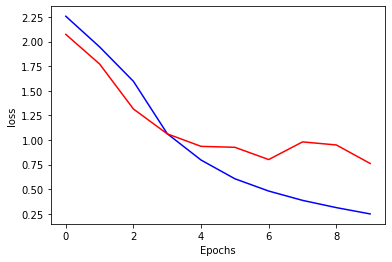

In [34]:
# Visualization of the training process on the loss function 
plt.plot(history[0]["loss"], color="b")
plt.plot(history[0]["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [35]:
history[0]["val_loss"]

[2.07356858253479,
 1.7723661661148071,
 1.3149243593215942,
 1.0622074604034424,
 0.9350911974906921,
 0.9254580140113831,
 0.8008520007133484,
 0.9803551435470581,
 0.949288547039032,
 0.7609995007514954]

## Confusion matrice

In [36]:
#prediction(s) (1 dim array)
predict = model_lstm.predict(test_data, callbacks=[checkpoint], verbose=0)
predict

array([[1.0000000e+00, 2.0155330e-08],
       [9.9999940e-01, 5.6334244e-07],
       [7.2780889e-01, 2.7219111e-01],
       ...,
       [9.3787014e-01, 6.2129837e-02],
       [9.1928965e-01, 8.0710381e-02],
       [1.2378968e-06, 9.9999881e-01]], dtype=float32)

In [37]:
#True target values
test = test_data.unbatch()
y = list(zip(*test))
y[1][0:5]

(<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [38]:
#To 1 dimension array -> predictions VS True values
predict_class = np.argmax(predict, axis = 1)
predict_class = predict_class.tolist()

In [39]:
#Confusion matrice
cf = tf.math.confusion_matrix(
    y[1], predict_class, weights=None, dtype=tf.dtypes.int32,
    name=None
)

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


<AxesSubplot:>

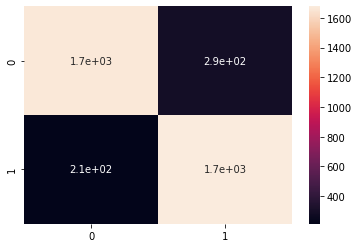

In [41]:
!pip install seaborn
import seaborn as sns
sns.heatmap(cf, annot=True)

In [ ]:
#Verification according to our training best accuracy !
mean_accuracy = (1603 + 1709)/((1603 + 1709) + (211 + 320))
print(mean_accuracy)